# Findings and Recommendations

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Load the dataset
data = pd.read_csv('../data/raw/data_for_predictions.csv')
data = data.drop('Unnamed: 0', axis=1)

# Display the first few rows
print(data.head(3))

# Check for missing values
print(data.isnull().sum())

# Check the distribution of the target variable
print(data['churn'].value_counts(normalize=True))

                                 id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944              0.0   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000              0.0   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000              0.0   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   

   forecast_price_pow_off_peak  ...  months_modif_prod  months_renewal  \
0                    40.606701  ...        

In [19]:
# Example: Create a feature for total consumption
data['total_cons'] = data['cons_12m'] + data['cons_gas_12m']

# Example: Create a feature for price sensitivity
data['price_sensitivity'] = data['forecast_price_energy_peak'] - data['forecast_price_energy_off_peak']

In [20]:
# Define features and target
X = data.drop(columns=['churn', 'id'])  # Drop 'id' as it's not a feature
y = data['churn']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [21]:
# Use SMOTETomek to handle class imbalance
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_processed, y)

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [23]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.9558
ROC-AUC Score: 0.9860
Precision: 0.9815
Recall: 0.9291
F1-Score: 0.9546


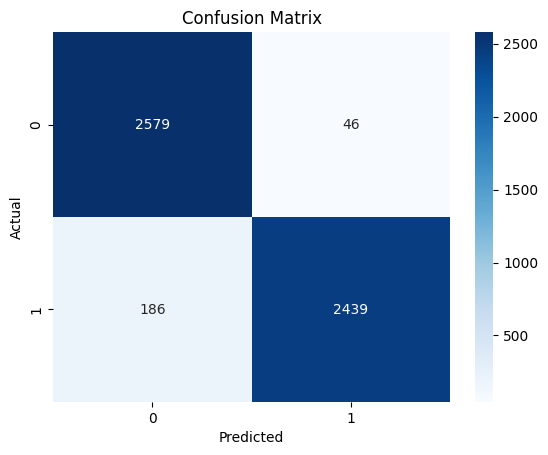


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      2625
           1       0.98      0.93      0.95      2625

    accuracy                           0.96      5250
   macro avg       0.96      0.96      0.96      5250
weighted avg       0.96      0.96      0.96      5250



In [24]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [25]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc', n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)

print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Best ROC-AUC Score: {best_roc_auc:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Model Accuracy: 0.9583
Best ROC-AUC Score: 0.9863
Best Precision: 0.9843
Best Recall: 0.9314
Best F1-Score: 0.9571


In [ ]:
# Fit preprocessor on training data
X_train = pd.DataFrame(X_train, columns=X.columns)
preprocessor.fit(X_train)

# Get numeric feature names (unchanged)
num_feature_names = numeric_features

# Get categorical feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Combine all feature names
feature_names = num_feature_names + cat_feature_names

# Now proceed with feature importance extraction
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances')
plt.show()